In [1]:
## Necesary libraries

In [2]:
# pip install opencv-python
# pip install dlib

In [3]:
### A pre-trained model for faciql keypoints detector
### Paper: https://www.semanticscholar.org/paper/One-millisecond-face-alignment-with-an-ensemble-of-Kazemi-Sullivan/d78b6a5b0dcaa81b1faea5fb0000045a62513567
### https://github.com/davisking/dlib-models/blob/master/shape_predictor_68_face_landmarks.dat.bz2


In [4]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import emoji

In [5]:
img = cv2.imread('./tony_stark.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale 
detector = dlib.get_frontal_face_detector()
rects = detector(gray, 1) # rects contains all the faces detected

In [6]:
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords
    
predictor = dlib.shape_predictor('./Models_face_points/shape_predictor_68_face_landmarks.dat')
for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    for (x, y) in shape:
        cv2.circle(img, (x, y), 2, (0, 0, 255), -1)

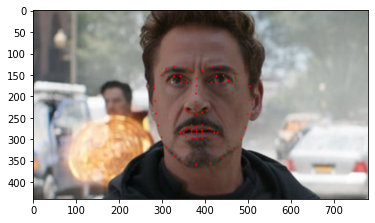

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [8]:
#### Capture video using webcam

In [11]:
import cv2
import dlib
import numpy as np

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

def eye_on_mask(mask, side):
    
#     [l, t, r, b] : list
#     left, top, right, and bottom most

    points = [shape[i] for i in side]
    points = np.array(points, dtype=np.int32)
    mask = cv2.fillConvexPoly(mask, points, 255)
    
    l = points[0][0]
    t = (points[1][1]+points[2][1])//2
    r = points[3][0]
    b = (points[4][1]+points[5][1])//2
    
    return mask , [l,t,r,b]

def find_eyeball_position(end_points, cx, cy):
    """Find and return the eyeball positions, i.e. left or right or top or normal"""
    
    x_left = abs(end_points[0] - cx)
    x_right = abs(end_points[2] - cx)
    x_ratio = x_left/x_right
    
    y_top = abs(end_points[1] - cy)
    y_down = abs(end_points[3] - cy)
    y_ratio = y_down/y_top
#     print(y_ratio)
    
#     print('X',x_left, x_right)
#     print('y',y_top, y_down)
    
    if (x_right < x_left) and x_ratio>=1.05:
        ## Center of eye closer to left side of face
        return 1
    elif (x_right > x_left) and x_ratio<=0.9:
        ## Center of eye closer to right side of face
        return 2
    elif (y_down > y_top) and y_ratio >=1.1:
        return 3
    else:
        return 0
    
###############################  
def print_eye_pos(img, left, right):
    """
    Print the side where eye is looking and display on image
    Parameters
    ----------
    img : Array of uint8
        Image to display on
    left : int
        Position obtained of left eye.
    right : int
        Position obtained of right eye.
            
            0 for normal
            1 for left
            2 for right
            3 for up
    Returns
    -------
    None.
    """
    if left == right and left==0:
        text = ''
        print('normal')
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(img, text, (30, 30), font,  
                   1, (0, 255, 255), 2, cv2.LINE_AA)
    elif right == 1:
        text = 'Looking left' + emoji.emojize(':U+1F914:')
        print('Looking left')
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(img, text, (30, 30), font,  
                   1, (0, 255, 255), 2, cv2.LINE_AA)
    elif right == 2:
        text = 'Looking right'
        print('Looking right')
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(img, text, (30, 30), font,  
                   1, (0, 255, 255), 2, cv2.LINE_AA)
    elif right == 3:
        print('Looking up')
        text = 'Looking up'
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(img, text, (30, 30), font,  
                   1, (0, 255, 255), 2, cv2.LINE_AA)
#############################################################

def contouring(thresh, mid, img, end_points, right=False):
    """
    Find the largest contour on an image divided by a midpoint and subsequently the eye position
    Parameters
    ----------
    thresh : Array of uint8
        Thresholded image of one side containing the eyeball
    mid : int
        The mid point between the eyes
    img : Array of uint8
        Original Image
    end_points : list
        List containing the exteme points of eye
    right : boolean, optional
        Whether calculating for right eye or left eye. The default is False.
    Returns
    -------
    pos: int
        the position where eyeball is:
            0 for normal
            1 for left
            2 for right
            3 for up
    """
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    try:
        cnt = max(cnts, key = cv2.contourArea)
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        if right:
            cx += mid
        cv2.circle(img, (cx, cy), 4, (0, 0, 255), 2)
        pos = find_eyeball_position(end_points, cx, cy)
        return pos
    except:
        pass

###########################
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./Models_face_points/shape_predictor_68_face_landmarks.dat')

left = [36, 37, 38, 39, 40, 41]
right = [42, 43, 44, 45, 46, 47]

cap = cv2.VideoCapture(0)
ret, img = cap.read()
thresh = img.copy()

cv2.namedWindow('image') ##debugging
kernel = np.ones((9, 9), np.uint8)

def nothing(x):
    pass
cv2.createTrackbar('threshold', 'image', 0, 255, nothing)

while(True):
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    for rect in rects:

        shape = predictor(gray, rect)
        shape = shape_to_np(shape)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask, points_left = eye_on_mask(mask, left)
        mask, points_right = eye_on_mask(mask, right)
        mask = cv2.dilate(mask, kernel, 5)
        eyes = cv2.bitwise_and(img, img, mask=mask)
        mask = (eyes == [0, 0, 0]).all(axis=2)
        eyes[mask] = [255, 255, 255]
        mid = (shape[42][0] + shape[39][0]) // 2
        eyes_gray = cv2.cvtColor(eyes, cv2.COLOR_BGR2GRAY)
        threshold = cv2.getTrackbarPos('threshold', 'image')
        _, thresh = cv2.threshold(eyes_gray, threshold, 255, cv2.THRESH_BINARY)
        thresh = cv2.erode(thresh, None, iterations=2) #1
        thresh = cv2.dilate(thresh, None, iterations=4) #2
        thresh = cv2.medianBlur(thresh, 3) #3
        thresh = cv2.bitwise_not(thresh)
        
        ### Eyes position (vector in 2D space):
        pos_left = contouring(thresh[:, 0:mid], mid, img, points_left)
        pos_right = contouring(thresh[:, mid:], mid, img, points_right, True)
#         print(pos_left, pos_right)

        ### Int for simplyfing eyes position:
        print_eye_pos(img, pos_left, pos_right)
#         text = 'testing annotations'
#         font = cv2.FONT_HERSHEY_SIMPLEX 
#         cv2.putText(img, text, (30, 30), font,  
#                    1, (0, 255, 255), 2, cv2.LINE_AA)
        for (x, y) in shape[36:48]:
            cv2.circle(img, (x, y), 2, (255, 0, 0), -1)
    # show the image with the annotations
    cv2.imshow('eyes', img)
    cv2.imshow("image", thresh)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Looking left
Looking right
Looking left
normal
normal
Looking up
Looking up
Looking left
Looking left
Looking right
Looking up
Looking right
Looking right
Looking right
Looking right
Looking right
Looking right
Looking left
Looking left
Looking up
Looking right
Looking up
Looking right
Looking right
Looking up
Looking right
Looking up
Looking left
Looking left
Looking left
Looking left
Looking up
Looking up
Looking right
Looking right
Looking up
Looking right
Looking up
Looking right
Looking right
Looking up
Looking up
Looking left
Looking up
Looking left
Looking right
Looking up
Looking up
normal
Looking up
normal
Looking up
Looking left
Looking left
Looking left
Looking left
Looking up
Looking up
Looking left
Looking up
normal
Looking up
Looking up
Looking left
Looking up
Looking up
Looking left
Looking up
Looking up
Looking up
Looking right
normal
Looking right
Looking up
Looking left
Looking up
Looking up
normal
Looking up
normal
Looking up
normal
Looking up
normal
Looking right
Lo

<ipython-input-11-5dccc139afd3>:40: RuntimeWarning: divide by zero encountered in long_scalars
  y_ratio = y_down/y_top


normal
normal
Looking right
normal
Looking right
Looking right
Looking right
normal
Looking up
normal
Looking left
Looking right
Looking left
Looking left
Looking left
Looking left
Looking left
Looking left


In [10]:
# def find_eyeball_position(end_points, cx, cy):
#     """Find and return the eyeball positions, i.e. left or right or top or normal"""
#     x_left = abs(end_points[0] - cx)
#     x_right = abs(end_points[2] - cx)
# #     x_ratio = (x_right-x_left)/(x_right+x_left)
    
#     y_top = abs(end_points[1] - cy)
#     y_down = abs(end_points[3] - cy)
# #     y_ratio = y_top - y_down
    
#     print('X',x_left, x_right)
#     print('y',y_top, y_down)
    
#     if (x_right > x_left): #and x_ratio>0.05:
#         ## Center of eye closer to left side of face
#         return 1
#     elif (x_right < x_left): #and x_ratio>0.05:
#         ## Center of eye closer to right side of face
#         return 2
#     elif (y_down > y_top): #and y_ratio >=1:
#         return 3
#     else:
#         return 0
    